In [ ]:
!pip install tensorflow
!pip install Pillow

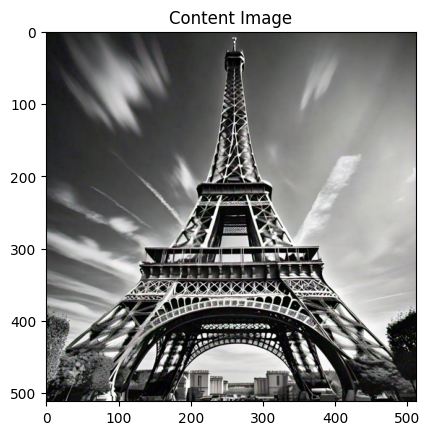

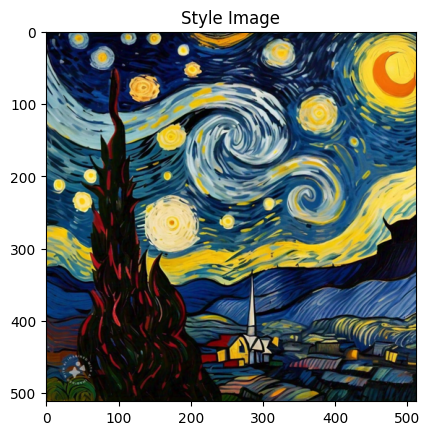

Epoch 0, Loss: 41895612416.0


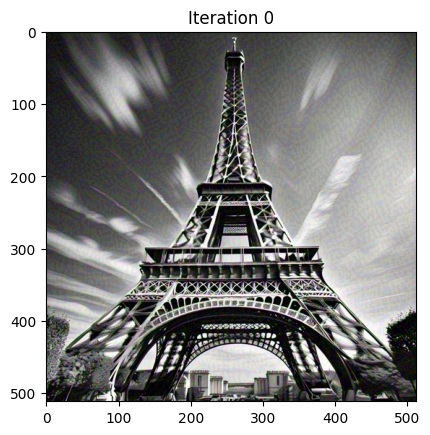

Epoch 200, Loss: 89491816.0


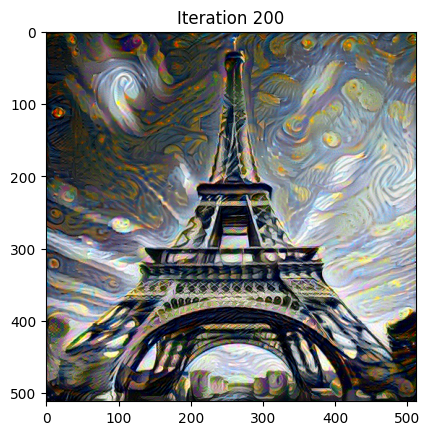

Epoch 400, Loss: 389957504.0


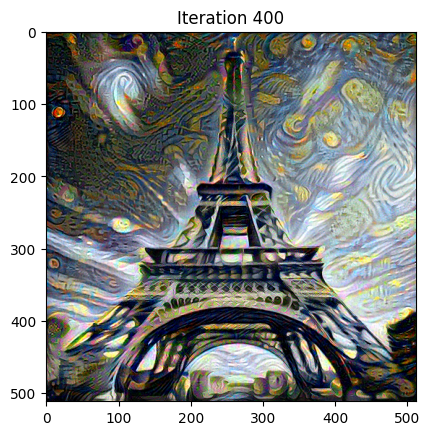

Epoch 600, Loss: 38642344.0


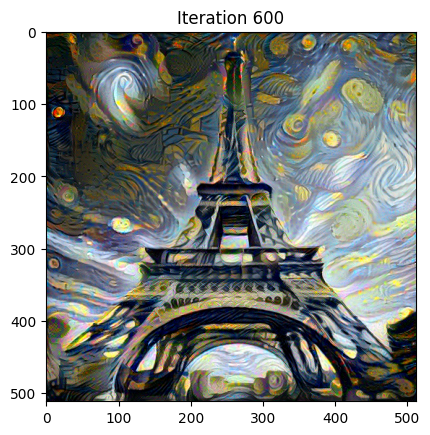

Epoch 800, Loss: 27280580.0


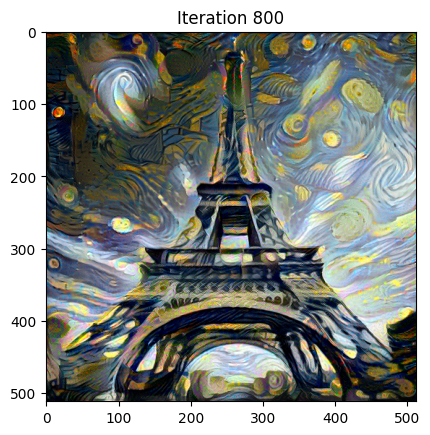

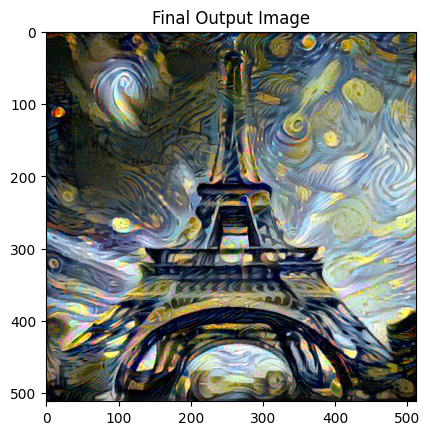

In [ ]:
import tensorflow as tf
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Function to preprocess image
def preprocess_image(image_path, target_size=(512, 512)):
    img = Image.open(image_path).convert('RGB')
    img = img.resize(target_size)  # Resize image to a fixed size
    img = np.array(img)
    img = tf.image.convert_image_dtype(img, tf.float32)  # Convert to float32 (0-1 range)
    img = img[tf.newaxis, :]  # Add batch dimension
    return img

# Load content and style images
content_image = preprocess_image('/content/content_image.jpg')
style_image = preprocess_image('/content/style_image.png')

# Function to display image
def show_img(img, title=None):
    img = tf.squeeze(img, axis=0)  # Remove batch dimension
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.show()

# Show content and style images
show_img(content_image, 'Content Image')
show_img(style_image, 'Style Image')

# VGG19 model for extracting content and style features
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
vgg.trainable = False

# Function to get intermediate layers for style/content representation
def style_content_model():
    # Pick specific layers for style and content features
    style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
    content_layers = ['block5_conv2']

    outputs = [vgg.get_layer(name).output for name in style_layers + content_layers]
    model = tf.keras.Model([vgg.input], outputs)
    return model

# Extract style and content features
extractor = style_content_model()
style_outputs = extractor(style_image * 255)  # Style image scaled
content_outputs = extractor(content_image * 255)  # Content image scaled

# Function to extract features from VGG
def extract_features(image, model):
    outputs = model(image * 255)  # Scale image to 255 before extracting features
    style_features = outputs[:5]  # First 5 layers are style
    content_features = outputs[5:]  # Last layer is content
    return style_features, content_features

style_features, content_features = extract_features(style_image, extractor)

# Function to compute style loss
def gram_matrix(input_tensor):
    channels = int(input_tensor.shape[-1])
    a = tf.reshape(input_tensor, [-1, channels])
    n = tf.shape(a)[0]
    gram = tf.matmul(a, a, transpose_a=True)
    return gram / tf.cast(n, tf.float32)

def compute_style_loss(style_outputs, style_targets):
    style_loss = 0
    weight_per_layer = 1.0 / len(style_outputs)
    for style_output, style_target in zip(style_outputs, style_targets):
        gram_style_output = gram_matrix(style_output)
        gram_style_target = gram_matrix(style_target)
        style_loss += weight_per_layer * tf.reduce_mean((gram_style_output - gram_style_target) ** 2)
    return style_loss

# Function to compute content loss
def compute_content_loss(content_output, content_target):
    return tf.reduce_mean((content_output - content_target) ** 2)

# Define optimizer and learning rate
opt = tf.optimizers.Adam(learning_rate=0.02)

# Function to train the model
@tf.function
def train_step(generated_image, extractor, content_targets, style_targets):
    with tf.GradientTape() as tape:
        style_outputs, content_outputs = extract_features(generated_image, extractor)
        style_loss = compute_style_loss(style_outputs, style_targets)
        content_loss = compute_content_loss(content_outputs[0], content_targets[0])
        loss = style_loss + content_loss
    gradients = tape.gradient(loss, generated_image)
    opt.apply_gradients([(gradients, generated_image)])
    return loss

# Initialize generated image (content image copy)
generated_image = tf.Variable(content_image)

# Style and content targets
style_targets, content_targets = extract_features(style_image, extractor)

# Train for multiple steps
epochs = 1000  # You can adjust the number of steps
for epoch in range(epochs):
    loss = train_step(generated_image, extractor, content_targets, style_targets)
    if epoch % 200 == 0:
        print(f"Epoch {epoch}, Loss: {loss}")
        show_img(generated_image, title=f"Iteration {epoch}")

# Show final generated image
show_img(generated_image, "Final Output Image")